In [2]:
import math
import numpy as np
import tqdm 
import torch
import matplotlib.pyplot as plt
%matplotlib inline
 

In [90]:
class Value : 
    def __init__(self,data,_children =(),_op='',label=''):
        self.data = data   
        self.grad = 0.0 
        self._backward = lambda : None # empty funtion if it makes sense saying it this way
        self._prev = set(_children)  
        self._op = _op 
        self.label = label 

    def __repr__(self): 
        return f"Value(data={self.data})"   

    def __add__(self,next):   
        next = next if isinstance(next, Value) else Value(next) 
        ret = Value(self.data+next.data,(self,next),'+')  
        # adding constant

        ''' 
            f = a + b 
            df/da  = 1  , df/db = 1 
        '''
        def _backward():   
            self.grad += 1.0*ret.grad # chain rule we keep changes instead of setting/assigning 
            next.grad += 1.0*ret.grad 
        
        ret._backward = _backward 
        #print(ret)
        return ret   
    
    def __mul__(self,next):  
        next = next if isinstance(next,Value) else Value(next)
        
        ''' 
            f = a * b 
            df/da  = b  , df/db = a 
        '''
       
        ret = Value(self.data*next.data,(self,next),'*')  
       
        def _backward() : 
            self.grad += next.data * ret.grad
            next.grad += self.data * ret.grad 
            print()
        
        ret._backward = _backward
        return ret 

    def __neg__(self) : 
        return self*-1
    
    def __sub__(self,next) : 
        return self + (-next)

    def __rmul__(self,next) :    
        return self*next  

    def __radd__(self,next) :
        return self+next 

    def tanh(self):  

        ''' 
            f = tanh(x) 
            df/dx = 1 - tanh(x)*tanh(x)

        '''
        x = self.data
        ret = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(ret,(self,),'tanh')  
        def _backward(): 
            self.grad += (1 - ret**2)*out.grad 
        
        out._backward = _backward
        return out 

    def __pow__(self,next) : 
        assert (isinstance(next,(int,float))) # only ints and floats  
        x = self.data
        out = Value(x**next,(self,),f'**{next}') 
        def _backward() :
            self.grad += out.grad *next* (self.data**(next-1)) 
        out._backward = _backward

        return out
    
    def __truediv__(self,next):
        return self*(next**-1)
    
    def exp(self) : 
        x = self.data
        out = Value(math.exp(x),(self,), 'exp')  
        def _backward() : 
            self.grad += out.data*out.grad 
        out._backward = _backward 
        return out


    def backward(self):    
        ord = []
        vis = set() 
        # do a topological sort
        def dfs(v): 
            if v not in vis:   
                vis.add(v)
                for u in v._prev :  
                    dfs(u)
                ord.append(v) 
        
        dfs(self)  
        print(ord)
        self.grad = 1.0 
        #print(ord)

        #  call backward for each node in topological order 
        for i in reversed(ord) : 
            i._backward()




In [79]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

[Value(data=6.881373587019543), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]




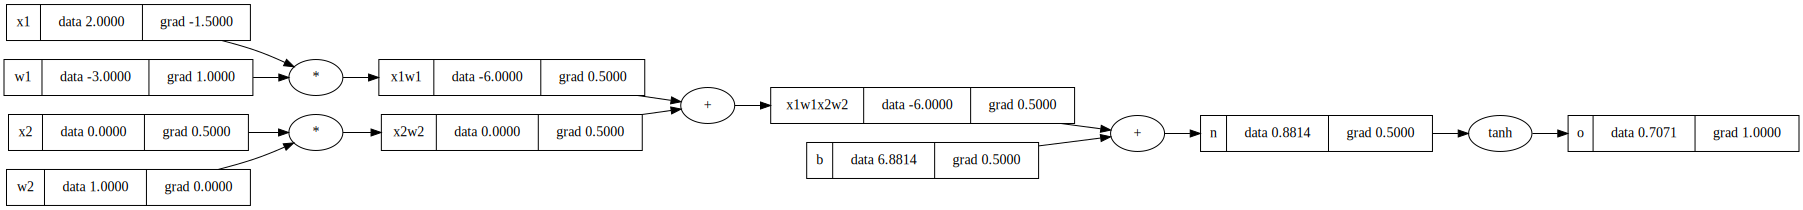

In [88]:
x1 = Value(2.0,label = 'x1') 
w1 = Value(-3.0,label = 'w1')
x2 = Value(0.0,label = 'x2')   
w2 = Value(1.0,label = 'w2')

x1w1 = x1*w1  
x1w1.label = 'x1w1' 

b = Value(6.8813735870195432,label = 'b')  #yoinked

x2w2 = x2*w2 
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1  + x2w2  
x1w1x2w2.label = 'x1w1x2w2 '
n = x1w1x2w2 + b  
n.label = 'n' 

o = n.tanh()


#e = (2*n).exp() 
#o = (e-1)/(e+1)
o.label = 'o'    
o.backward()
draw_dot(o) 

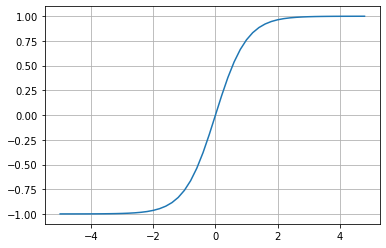

In [7]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()



[Value(data=1), Value(data=6.881373587019543), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=2), Value(data=1.7627471740390863), Value(data=5.828427124746192), Value(data=6.828427124746192), Value(data=0.1464466094067262), Value(data=-1), Value(data=4.828427124746192), Value(data=0.7071067811865477)]






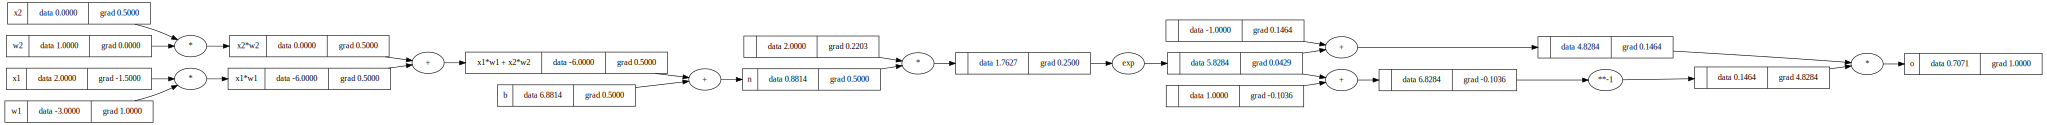

In [91]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---- tanh with functions
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [92]:
#comparing with torch and tensorflow 